# Anaysis pipeline of _D. novamexicana_ post-mating RNAseq 

## Load packages and generate some useful functions

The analysis below relies on several R packages and custom functions that are used for plotting and extracting gene-level annotation info. The packages can be defined and loaded like so:

In [1]:
req_packages = c("Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "ggplot2", "ggrepel", 
                 "ggthemes", "GO.db", "goseq", "grid", "gridExtra", "imager", 
                 "plotly", "qvalue", "reshape", "Rmisc", "splitstackshape", 
                 "statmod", "VennDiagram", "ggthemr")

lapply(req_packages, require, character.only = TRUE)

# The Cowplot package changes the default themes of ggplot2. Set the default theme like so:
theme_set(theme_gray())

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignette

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

[[21]]
[1] TRUE

[[22]]
[1] TRUE

[[23]]
[1] TRUE

The functions used in the analyses are in the file "Functions2.R":

In [2]:
source("Functions2.R")

These functions include: 
  * `MA_Bplot`: a function for generating MA plots and histograms of genes above 2-fold abundance
  * `plotGenePM`: for plotting mean±s.e TPM expression barplots (plotGenePM_RT plots Reproductive Tract expression only)
  * `plotHeatmap`: generic plotter for heatmaps with ggplot (requires matrix)
  * `calcSpecificity`: a function for calculating gene-wise tissue-specificity
  * `geneLookupG`: a function for extracting Trinotate annotations
  * `heatmap3`: for plotting heatmaps
  * ... and other miscellaneous RNAseq and R functions

### Load annotations, PAML data and orthology information

Some annotation files were generated from the _D. virilis_ transcriptome—in addition to miscellaneous population genetic data from the species group—that can be used here to annotate transcripts at various stages of the analysis. Load that data and process it for further use.

#### Annottations:
A Trinotate report and accompanying Gene Ontology assignments were produced in an earlier study that can be used here:

In [3]:
grpTrinotate = read.csv("Annotations/Trinotate_report_dvir1.06_subset.txt", header = T, sep = "\t", na.strings = ".", stringsAsFactors=FALSE)
GO_info = read.table("Annotations/Trinotate_report_dvir1.06_gene_ontology.txt", header=F, row.names=1,stringsAsFactors=F)

Another useful annotation file is the gene features file:

In [4]:
gffRecord = read.table("Annotations/FBgn_ID_name_coordinates.txt", header = T)

From FlyBase we can obtain information on orthology to _D. melanogaster_:

In [5]:
melOrths = read.table(file = "Annotations/mel_orths.txt", header = T)
melOrthsAll = aggregate(mel_GeneSymbol~FBgn_ID, data = melOrths, toString)

Finally, we can combine the files above for convenience:

In [6]:
Annots = merge(merge(melOrthsAll, grpTrinotate, all=TRUE), gffRecord, all=TRUE)

#### PAML data:

Also from the previous RNAseq study on the virilis sub-group, some PAML and Ka/Ks results can be used here:

In [7]:
tmp.FB.names = unique(subset(Annots, select=c("FBgn_ID", "FBtr_ID")))
paml.data = read.csv(file = "Annotations/PAML.branchSite.ALL.results.txt", header = T, sep = "\t")
paml.data = merge(tmp.FB.names, paml.data, all=T)
paml.data = merge(gffRecord, paml.data, all=T)
KaKs.data = read.csv(file = "Annotations/KaKs.ALL.results.txt", header = T, sep = "\t", check.names = F)
KaKs.data = merge(tmp.FB.names, KaKs.data, all=T)
KaKs.data = merge(gffRecord, KaKs.data, all=T)

### Load expression matrices:

The raw counts from each sample obtained from `eXpress` can be loaded as a data-frame:

In [8]:
DnovPM.dvir1.06.CountsMatrix = read.table("ExpressionData/genes_DnovPM_dvi1.06.counts.matrix", header=T, row.names=1, com='', check.names=F)

The normalized expression values—expressed in TPM units—can also be loaded as a data-frame:

In [9]:
DnovPM.dvir1.06.TmmMatrix = read.table("ExpressionData/genes_DnovPM_dvi1.06.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)

Finally, a table of aggregate gene number by minimum TPM is usefull to estimate the number of expressed genes in the dataset:

In [10]:
DnovPM.dvir1.06.TpmMatrix.cbmt = read.table("ExpressionData/genes_DnovPM_dvi1.06.TPM.not_cross_norm.counts_by_min_TPM", header = T)

### Read in sample information: 

The `samples.txt` file describes the replicate:sample mapping, and is required in various steps later:

In [11]:
DnovPM.Samples_data = read.table("ExpressionData/samples.txt", header=F, check.names=F, fill=T)
DnovPM.Samples_data = DnovPM.Samples_data[DnovPM.Samples_data[,2] != '',]

## QC and filtering:

#### Barplot of gene counts by sample

After read trimming and filtering out low quality reads, we can check the library sizes of the samples to see if we satisfy the 10-20 million read minimum:

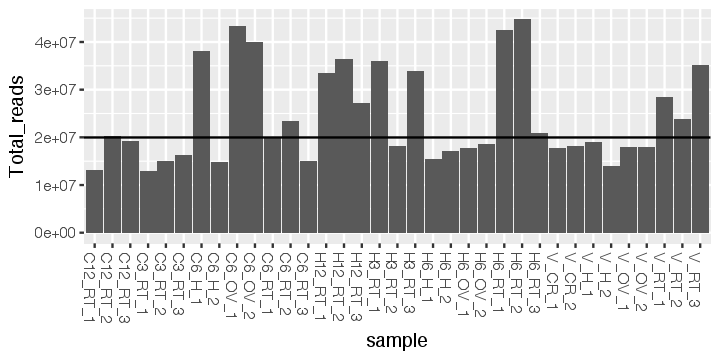

In [12]:
libSizes <- as.data.frame(colSums(DnovPM.dvir1.06.CountsMatrix))
libSizes <- cbind(sample = row.names(libSizes), libSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("sample", "Total_reads")
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(libSizes, aes(sample, Total_reads)) + 
    geom_bar(stat="identity") + 
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    geom_hline(yintercept = 20000000)

Looks like all the samples have >10 million reads, so the read counts look OK.

#### Boxplot of log10(TPM) across samples

To get a sense for broad expression patterns across samples, we can generate boxplots of TPM expression across samples to see if there are large median differences between samples/replicates:

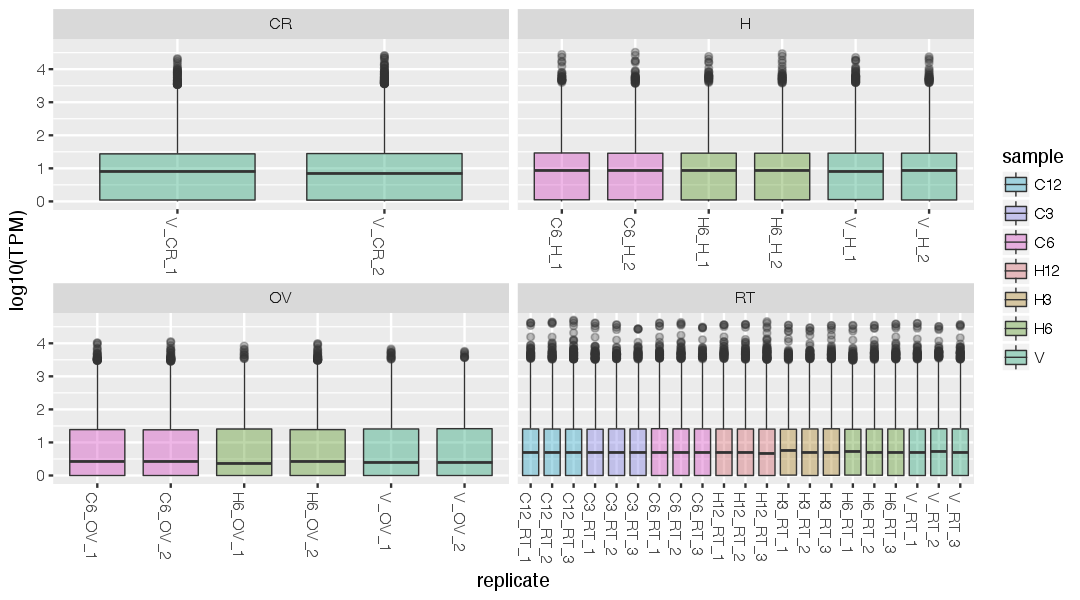

In [13]:
m.expData<-melt(as.matrix(DnovPM.dvir1.06.TmmMatrix))
colnames(m.expData) <- c("gene_id", "replicate", "TPM")
m.expData.exp<- within(m.expData, replicate<-data.frame(do.call('rbind', strsplit(as.character(replicate),'_',fixed=TRUE))))
m.expData<-data.frame(m.expData, m.expData.exp$replicate$X1, m.expData.exp$replicate$X2, m.expData.exp$replicate$X3)
colnames(m.expData) <- c("gene_id", "replicate", "TPM", "sample", "tissue", "rep_num")
m.expData$TPM <- m.expData$TPM + 1
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(m.expData) + 
    geom_boxplot(aes(x = replicate, y = log10(TPM), fill = sample), size = 0.3, alpha = I(1/3)) + 
    facet_wrap(~tissue, scales = "free_x") +
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    scale_fill_hue(l = 50, h.start = 200)

This is almost useless, but shows that all samples have roughly the same median expression values and similar spread across genes.

#### Estimate of the number of expressed genes (Brian Haas' method) 

Several approaches can be used to filter out genes with little to no expression. This step is necessary because it reduces the potential for false-positives and improves the strength of detecting differentially expressed genes. One approach that Brian Haas uses with _de novo_ assembled transcripts (which have lots of garbage transcripts) to is to plot the aggregate number of genes as a function of minimum TPM. Towards low TPM values, the curve expands and inflates the true number of expressed genes. Thus, fitting a line along the curve provides a reasonable estimate of the true number of expressed genes as the value of the y-intercept.

To accomplish this, we first extract the "trully expressed genes" (in this case, between 10 and 100 TPM):

In [14]:
DnovPM_filt_data = DnovPM.dvir1.06.TpmMatrix.cbmt[DnovPM.dvir1.06.TpmMatrix.cbmt[,1] > -100 & DnovPM.dvir1.06.TpmMatrix.cbmt[,1] < -10,]

Now we a perform a linear regression on this filtered subset of the data and display the value of the Y-intercept:

In [15]:
DnovPM_fit = lm(DnovPM_filt_data[,2] ~ DnovPM_filt_data[,1])
print(DnovPM_fit)


Call:
lm(formula = DnovPM_filt_data[, 2] ~ DnovPM_filt_data[, 1])

Coefficients:
          (Intercept)  DnovPM_filt_data[, 1]  
               9185.3                   69.4  



We can also plot the curve and linear fit:

Warning message:
"Removed 948 rows containing missing values (geom_point)."

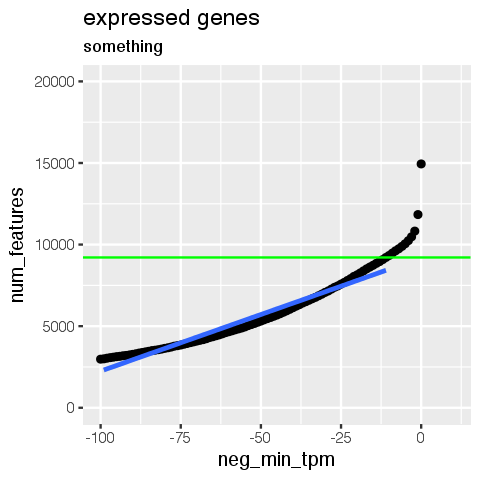

In [16]:
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(DnovPM.dvir1.06.TpmMatrix.cbmt, aes(neg_min_tpm,num_features)) + 
    geom_point() +  
    scale_x_continuous(limits=c(-100,10)) + 
    scale_y_continuous(limits=c(0,20000)) + 
    geom_smooth(data=DnovPM_filt_data, method = "lm") + 
    geom_hline(yintercept = 9185, colour = "green") + ggtitle("expressed genes", subtitle = "something")

Out of ~1500 genes, roughly 9000 should remain after filtering lowly expressed geenes. We can filter by minimum read count to get ~9180 genes remaining in the dataset:

In [17]:
DnovPM_max_gene_expr_per_row = apply(DnovPM.dvir1.06.CountsMatrix, 1, max)
DnovPM.dvir1.06.CountsMatrix.min400count = DnovPM.dvir1.06.CountsMatrix[DnovPM_max_gene_expr_per_row >= 400,,drop=F ]

In [18]:
nrow(DnovPM.dvir1.06.CountsMatrix.min400count)

[1] 9164

#### Create DGE object

In [19]:
## calculate dispersion
d <- DGEList(counts = DnovPM.dvir1.06.CountsMatrix.min400count, group = DnovPM.Samples_data$V1)
d <- calcNormFactors(d)
d <- estimateCommonDisp(d)
d <- estimateTagwiseDisp(d)
summary(d$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004976 0.010770 0.015760 0.060840 0.029190 1.886000 

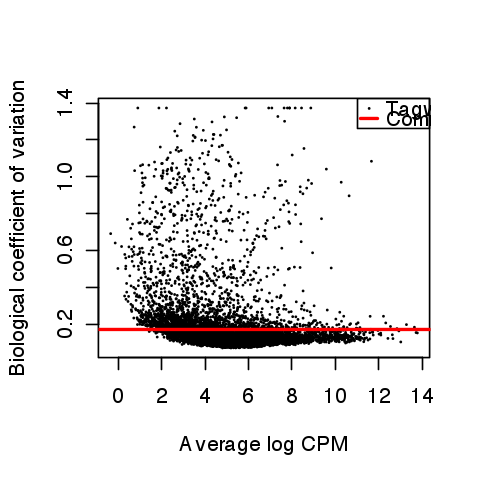

In [20]:
## Plot biological coefficient of variation
plotBCV(d)

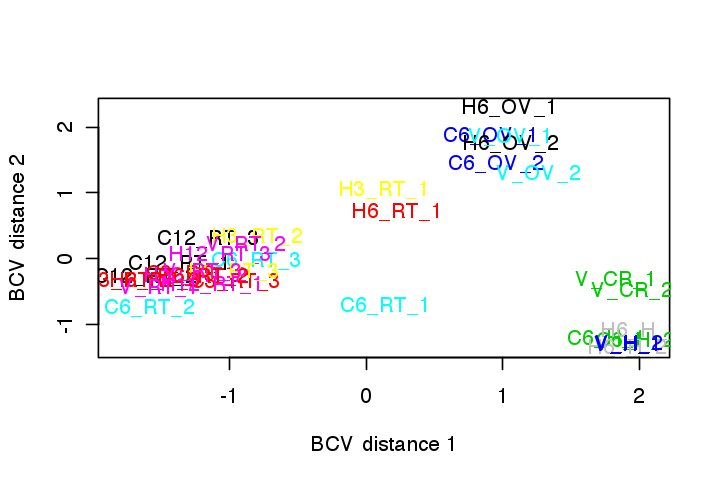

In [21]:
## Plot grouping of samples
options(repr.plot.width = 6, repr.plot.height = 4)
plotMDS(d, method = "bcv", col=as.numeric(d$samples$group))

Three samples look like they are not grouping with theri respective replicates:
1. C6_RT_1
2. H3_RT_1
3. H6_RT_1 

These samples can be removed from analyses below.

for plotting:: min.raw: 0.234436110565128 max.raw: 1


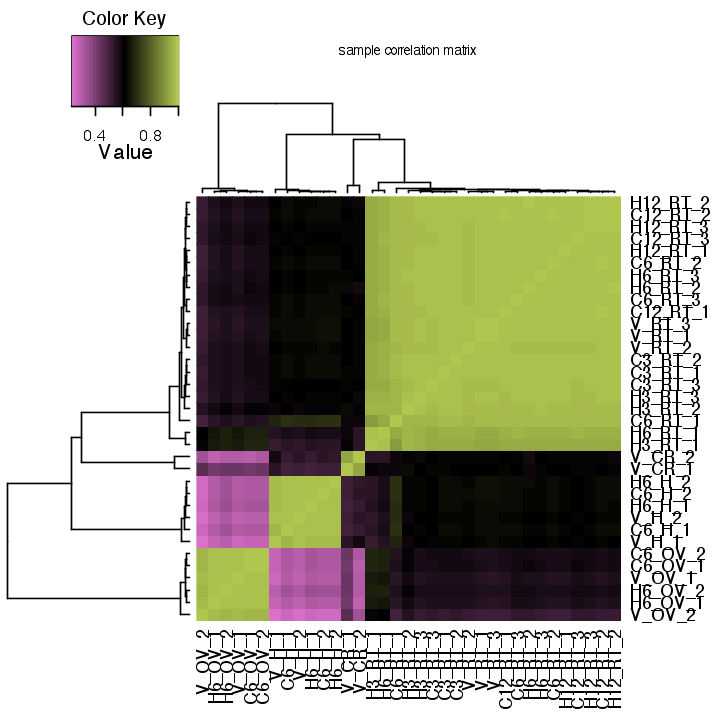

In [22]:
## Plot sample correlation
data = log2(DnovPM.dvir1.06.CountsMatrix.min400count+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 6, repr.plot.height = 6)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

Warning message:
"Removed 8 rows containing missing values (position_stack)."Warning message:
"Removed 3079 rows containing missing values (geom_point)."

Warning message:
"Removed 13 rows containing missing values (position_stack)."Warning message:
"Removed 2817 rows containing missing values (geom_point)."

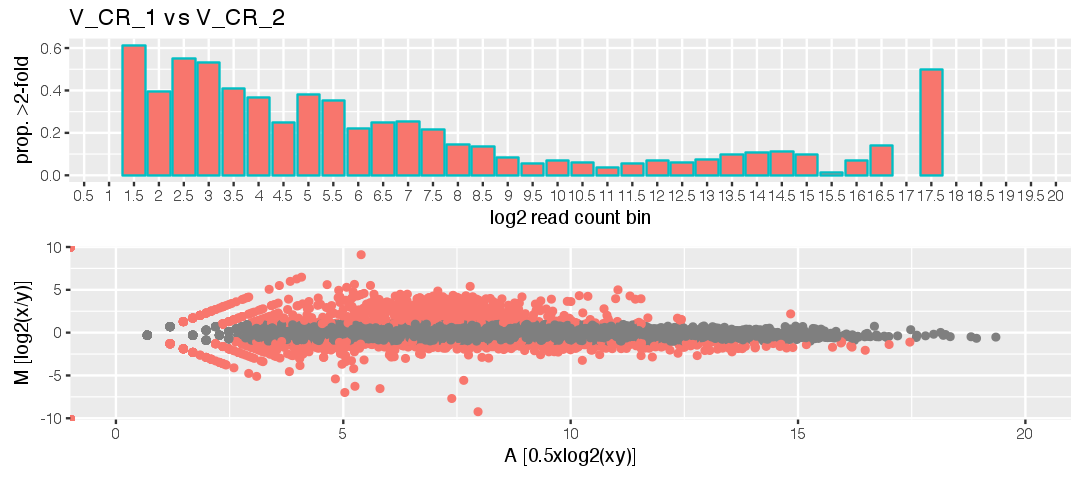

Warning message:
"Removed 16 rows containing missing values (position_stack)."Warning message:
"Removed 2724 rows containing missing values (geom_point)."

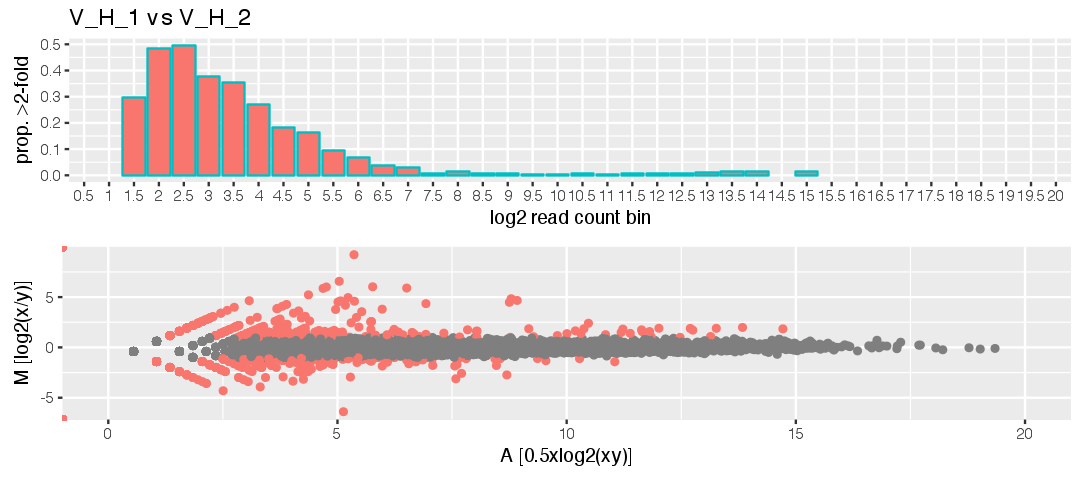

Warning message:
"Removed 13 rows containing missing values (position_stack)."Warning message:
"Removed 2843 rows containing missing values (geom_point)."

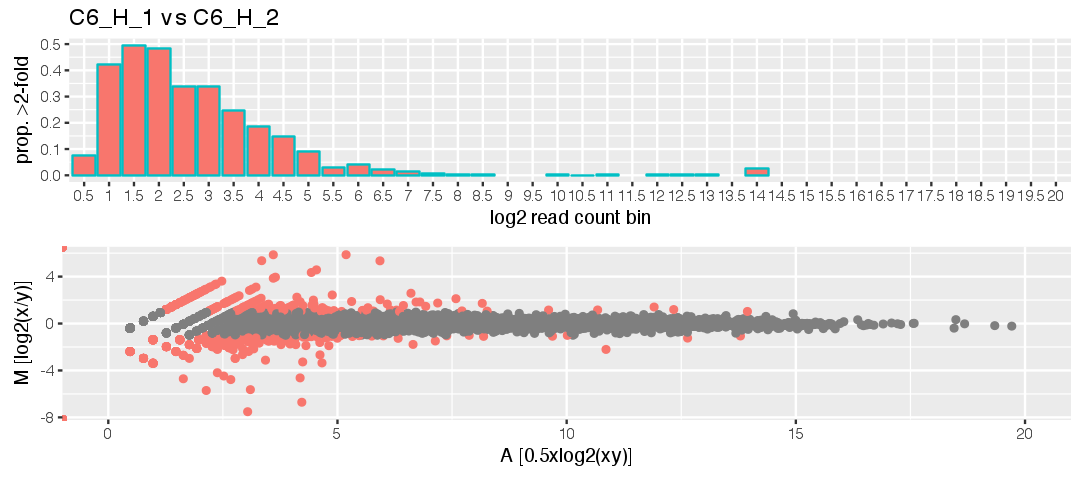

Warning message:
"Removed 10 rows containing missing values (position_stack)."Warning message:
"Removed 3977 rows containing missing values (geom_point)."

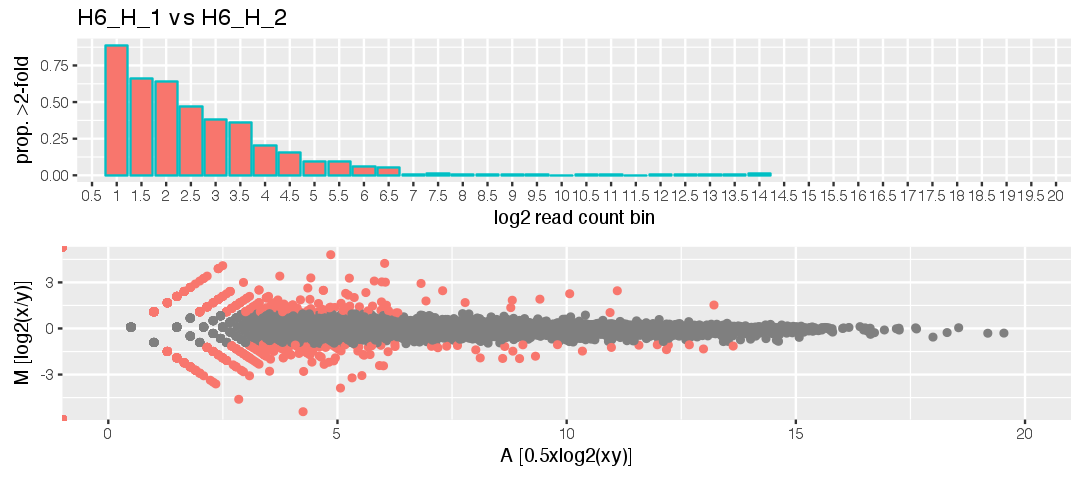

Warning message:
"Removed 13 rows containing missing values (position_stack)."Warning message:
"Removed 4060 rows containing missing values (geom_point)."

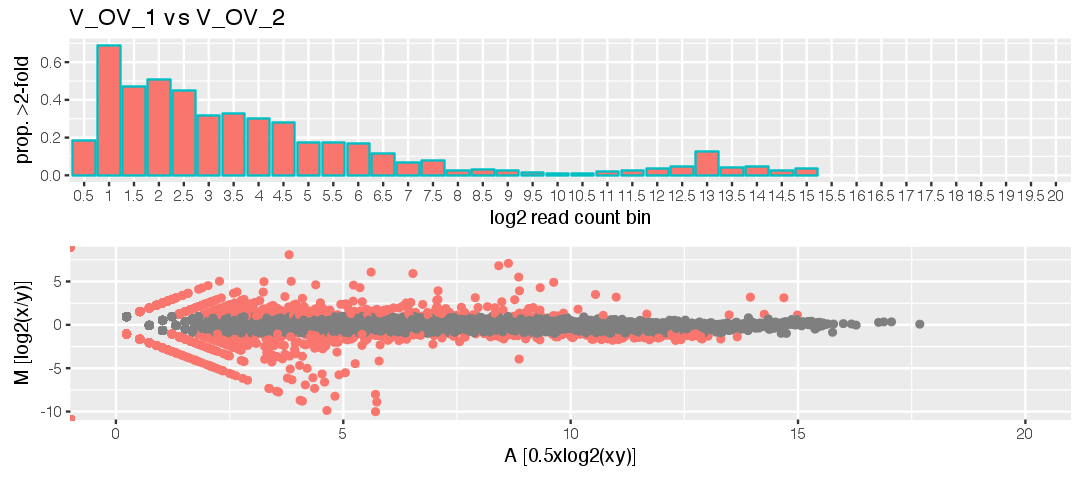

Warning message:
"Removed 14 rows containing missing values (position_stack)."Warning message:
"Removed 4152 rows containing missing values (geom_point)."

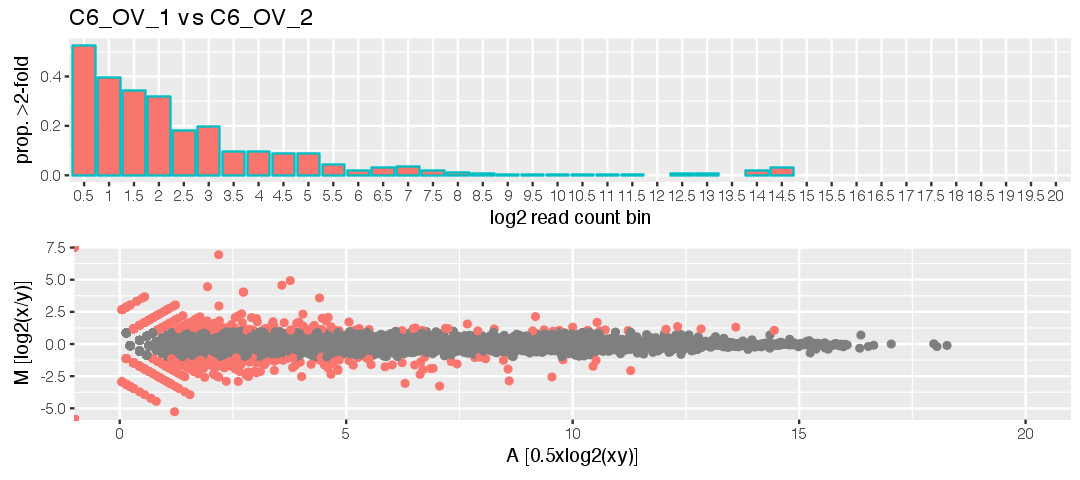

Warning message:
"Removed 15 rows containing missing values (position_stack)."Warning message:
"Removed 3598 rows containing missing values (geom_point)."

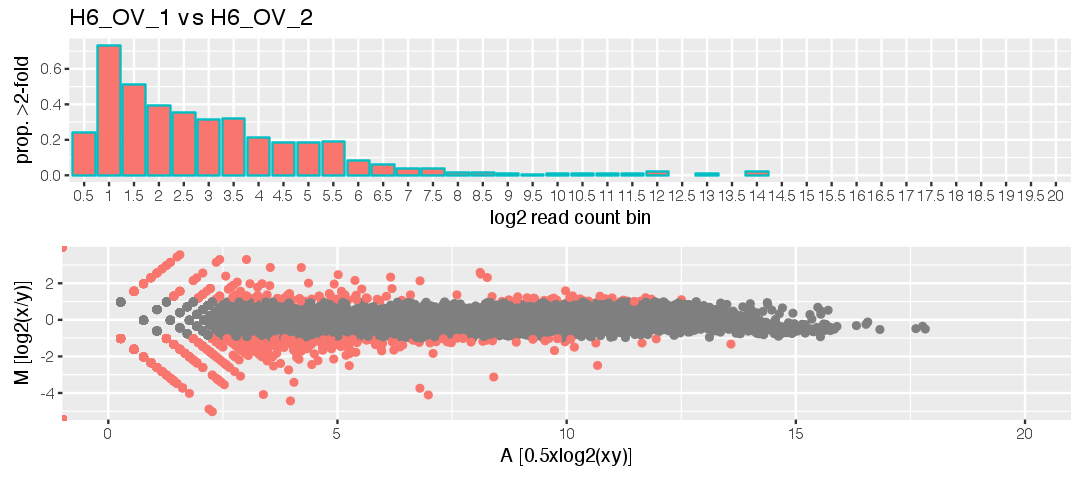

Warning message:
"Removed 14 rows containing missing values (position_stack)."Warning message:
"Removed 3629 rows containing missing values (geom_point)."

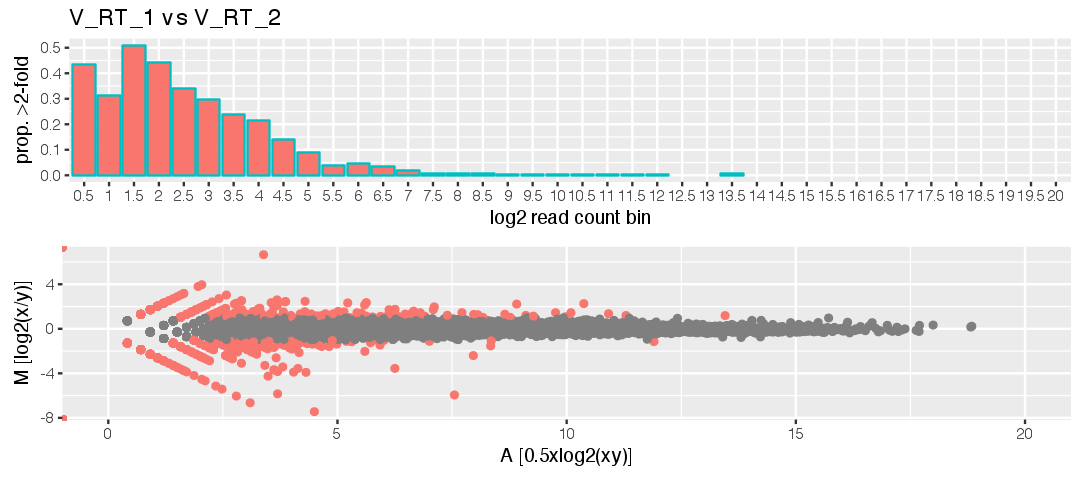

Warning message:
"Removed 17 rows containing missing values (position_stack)."Warning message:
"Removed 3525 rows containing missing values (geom_point)."

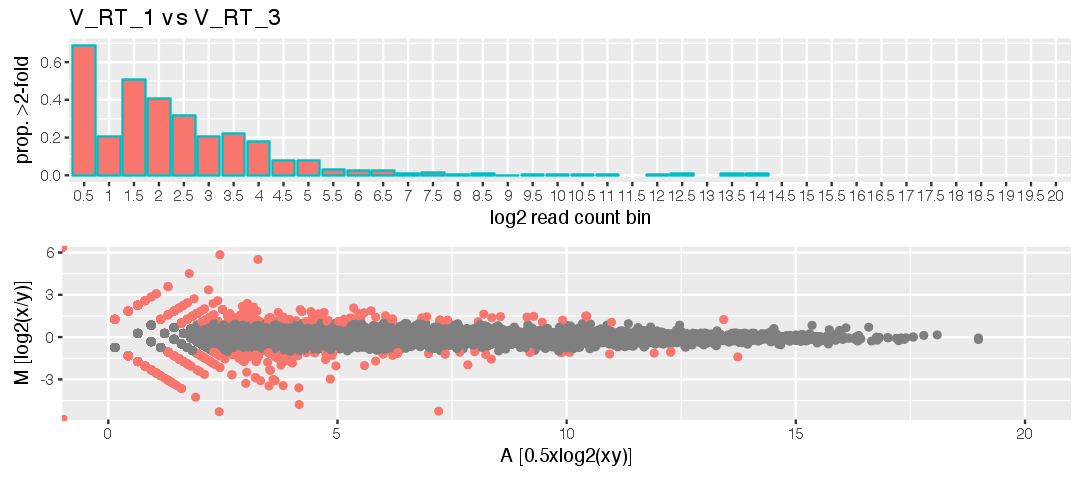

Warning message:
"Removed 14 rows containing missing values (position_stack)."Warning message:
"Removed 3812 rows containing missing values (geom_point)."

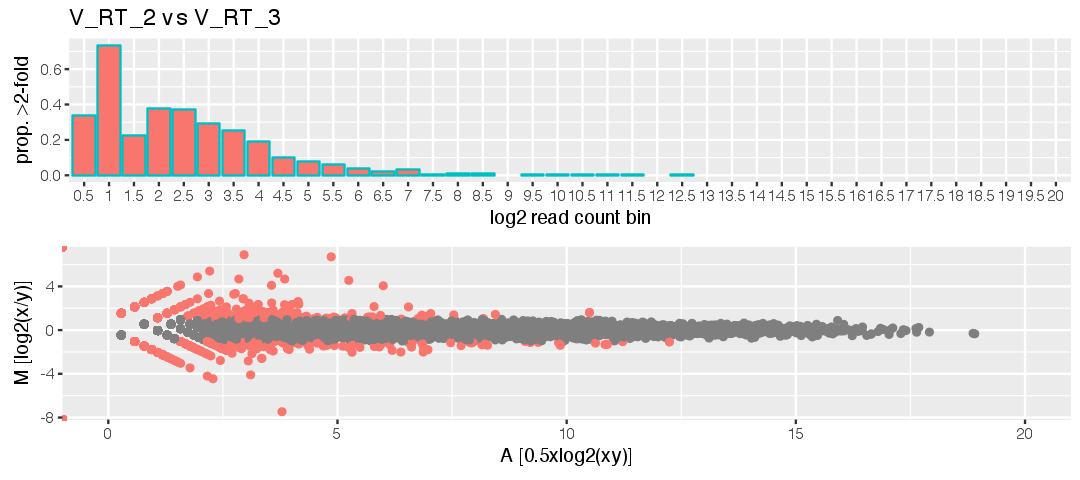

Warning message:
"Removed 18 rows containing missing values (position_stack)."Warning message:
"Removed 3716 rows containing missing values (geom_point)."

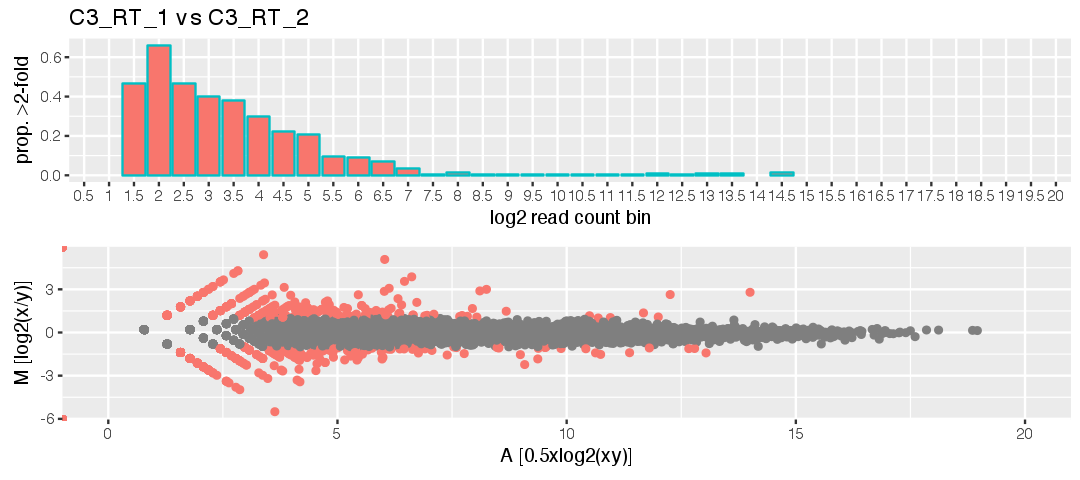

Warning message:
"Removed 13 rows containing missing values (position_stack)."Warning message:
"Removed 3704 rows containing missing values (geom_point)."

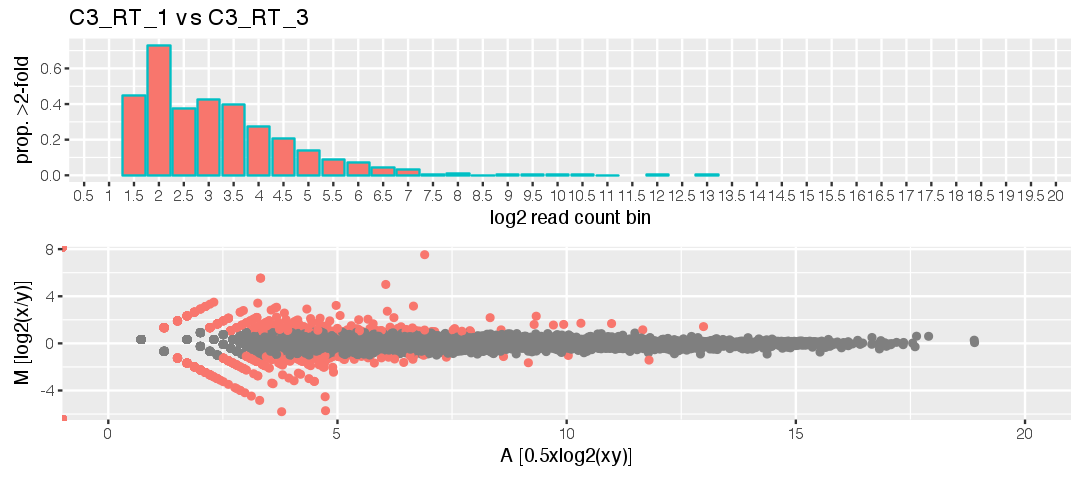

Warning message:
"Removed 19 rows containing missing values (position_stack)."Warning message:
"Removed 3468 rows containing missing values (geom_point)."

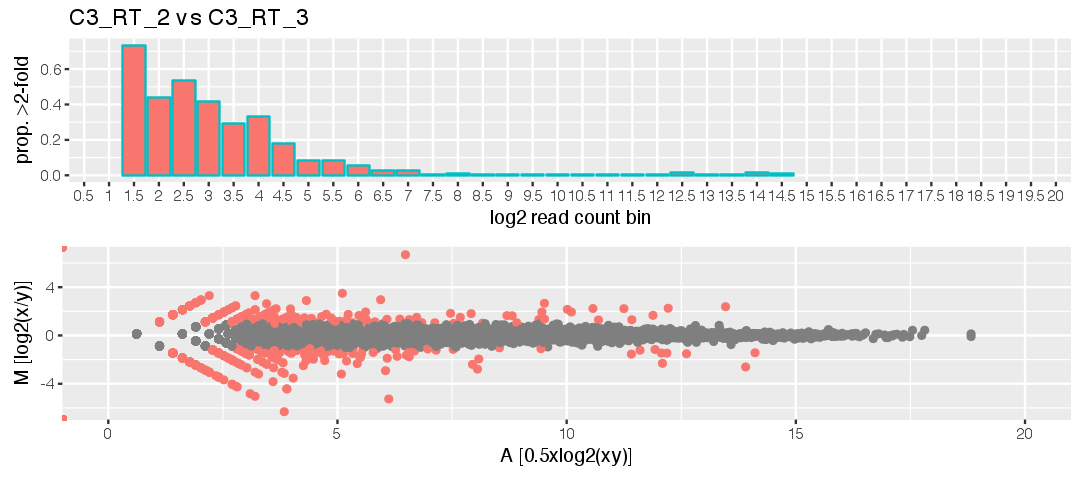

Warning message:
"Removed 12 rows containing missing values (position_stack)."Warning message:
"Removed 3542 rows containing missing values (geom_point)."

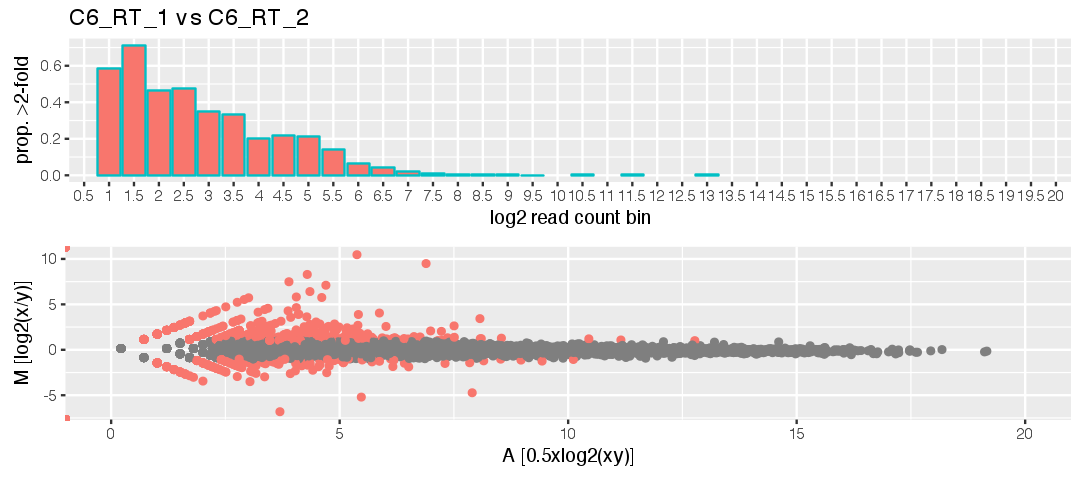

Warning message:
"Removed 13 rows containing missing values (position_stack)."Warning message:
"Removed 3692 rows containing missing values (geom_point)."

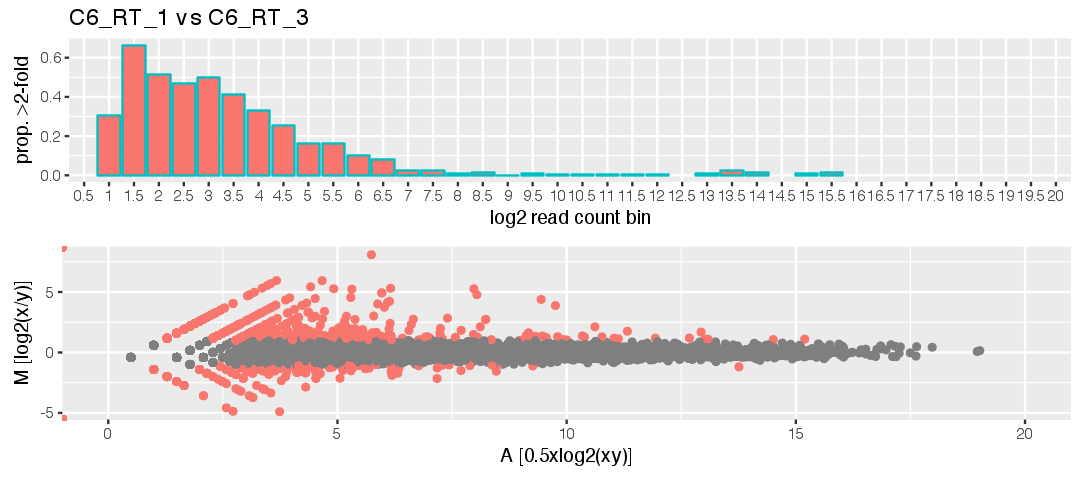

Warning message:
"Removed 19 rows containing missing values (position_stack)."Warning message:
"Removed 3703 rows containing missing values (geom_point)."

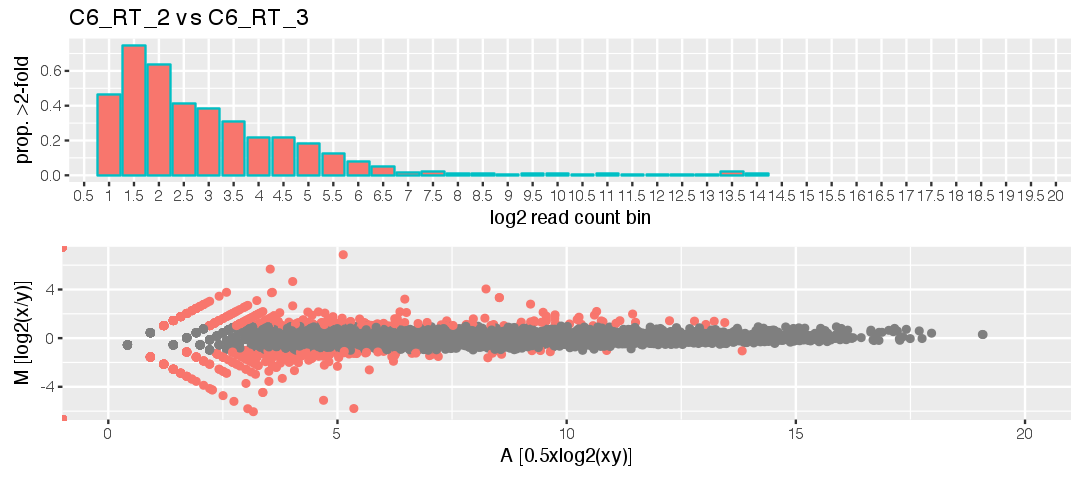

Warning message:
"Removed 13 rows containing missing values (position_stack)."Warning message:
"Removed 3713 rows containing missing values (geom_point)."

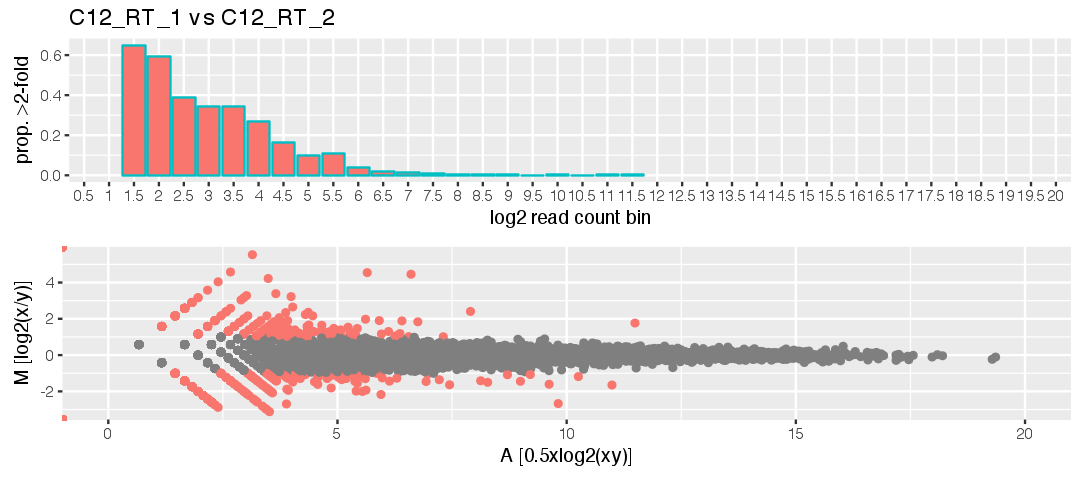

Warning message:
"Removed 16 rows containing missing values (position_stack)."Warning message:
"Removed 3637 rows containing missing values (geom_point)."

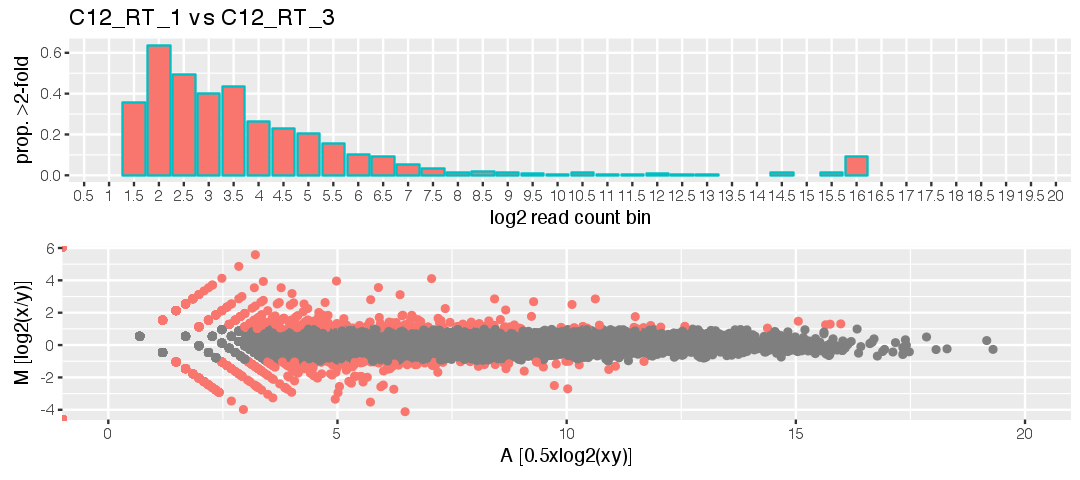

Warning message:
"Removed 16 rows containing missing values (position_stack)."Warning message:
"Removed 3338 rows containing missing values (geom_point)."

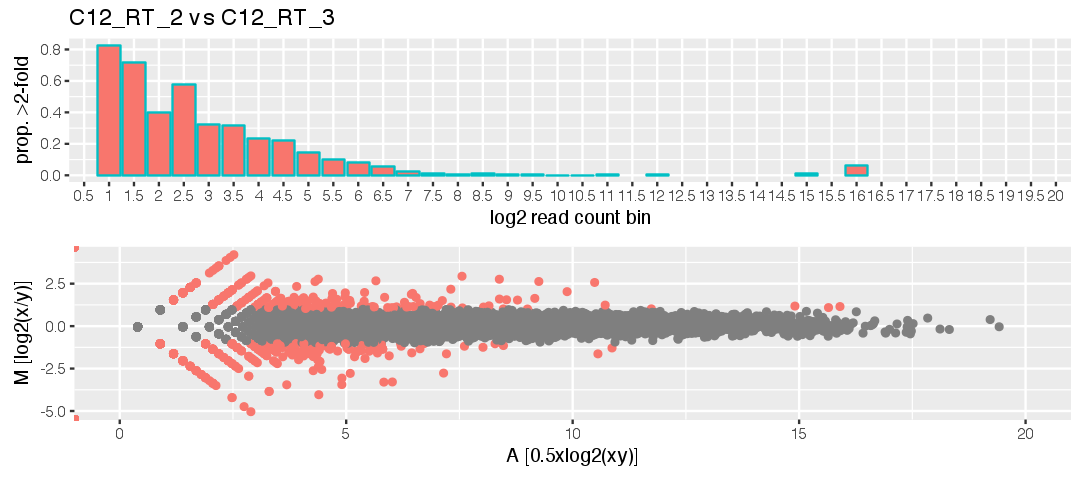

Warning message:
"Removed 12 rows containing missing values (position_stack)."Warning message:
"Removed 3332 rows containing missing values (geom_point)."

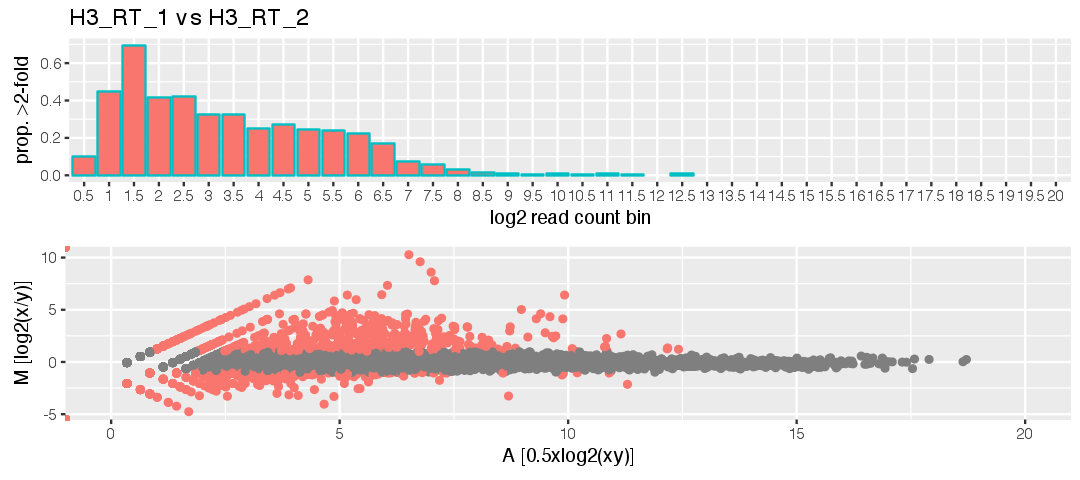

Warning message:
"Removed 15 rows containing missing values (position_stack)."Warning message:
"Removed 3448 rows containing missing values (geom_point)."

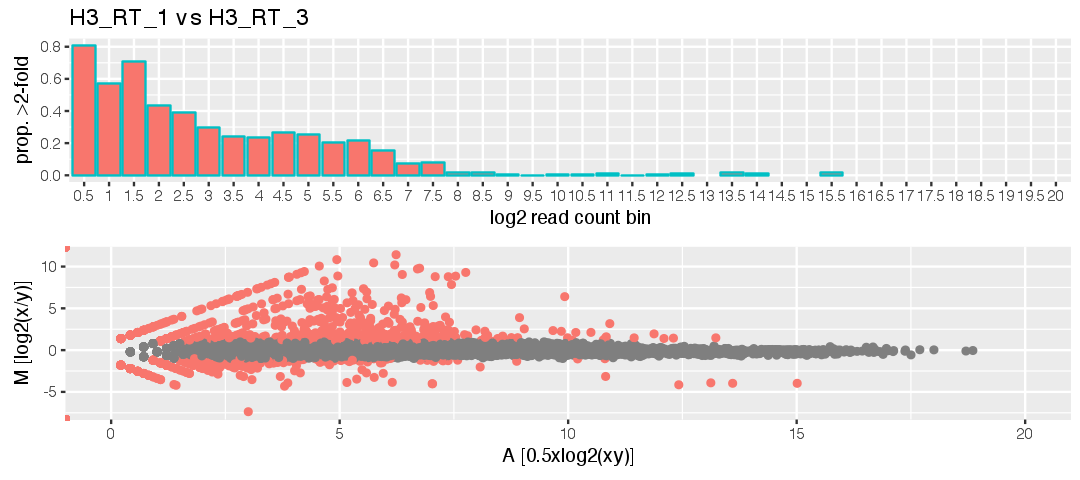

Warning message:
"Removed 13 rows containing missing values (position_stack)."Warning message:
"Removed 3292 rows containing missing values (geom_point)."

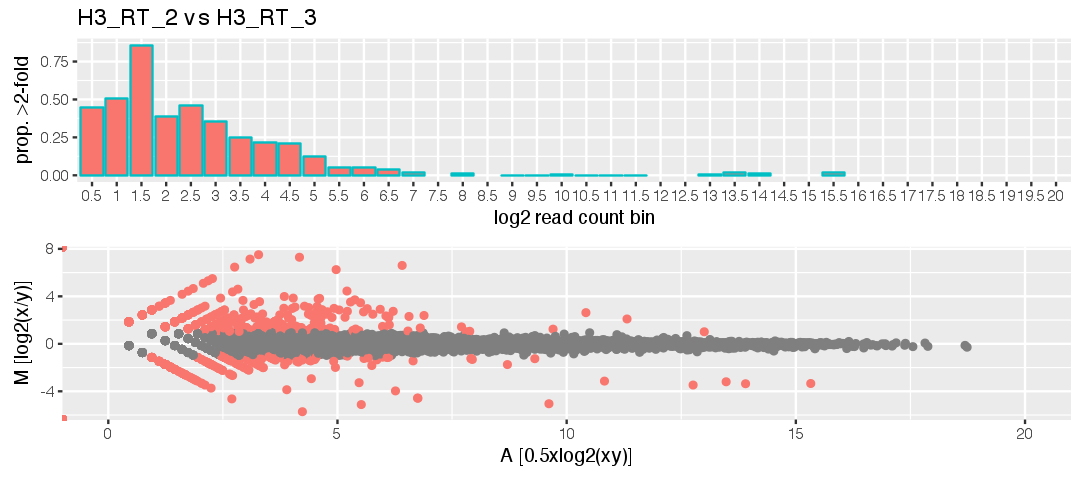

Warning message:
"Removed 14 rows containing missing values (position_stack)."Warning message:
"Removed 3347 rows containing missing values (geom_point)."

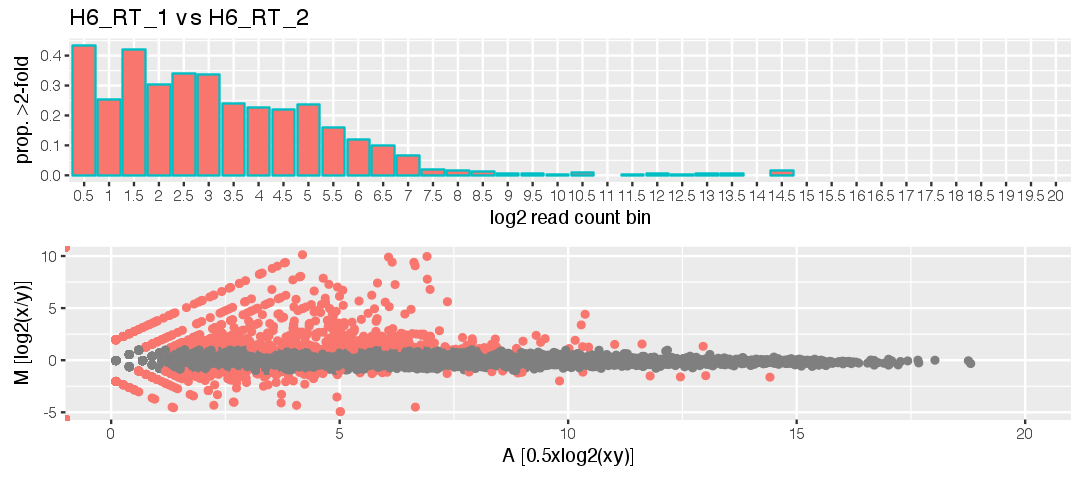

Warning message:
"Removed 13 rows containing missing values (position_stack)."Warning message:
"Removed 3407 rows containing missing values (geom_point)."

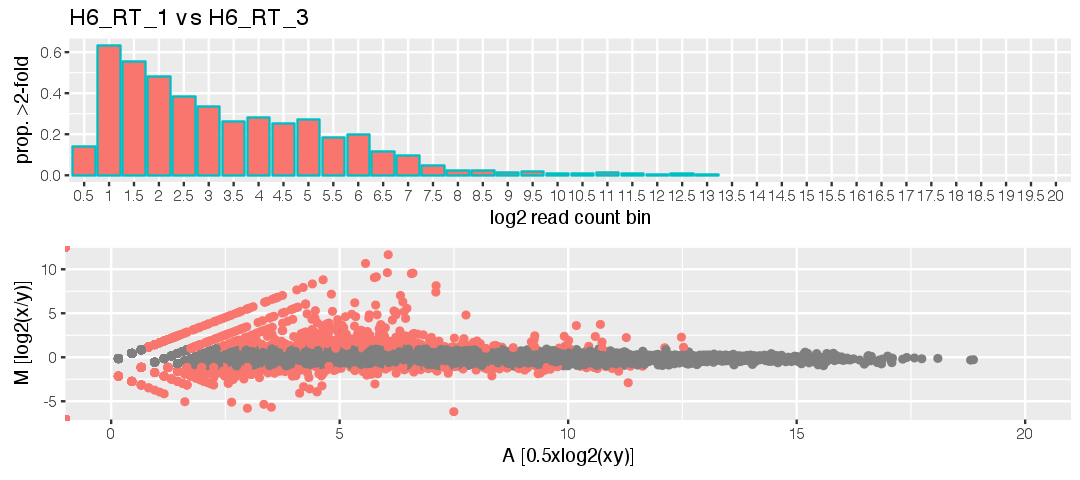

Warning message:
"Removed 22 rows containing missing values (position_stack)."Warning message:
"Removed 3503 rows containing missing values (geom_point)."

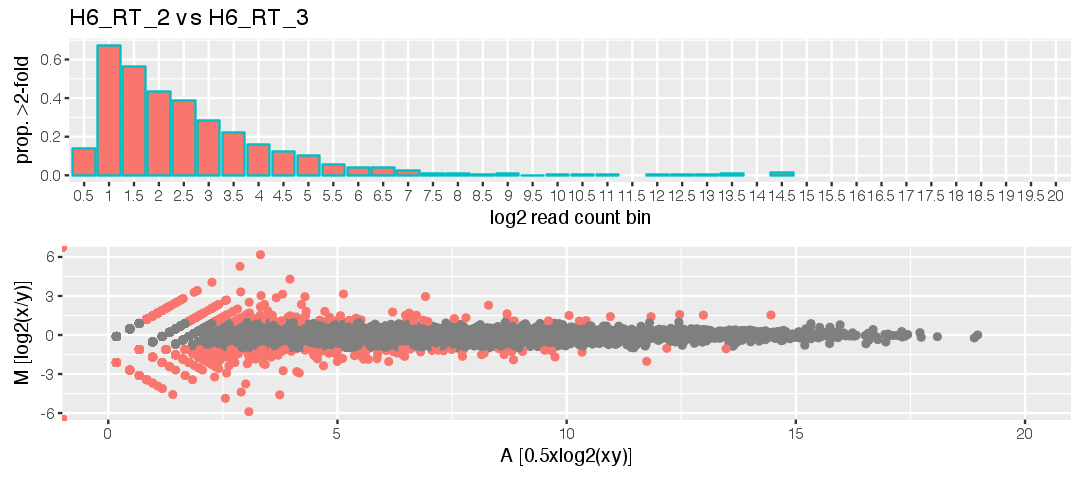

Warning message:
"Removed 16 rows containing missing values (position_stack)."Warning message:
"Removed 3531 rows containing missing values (geom_point)."

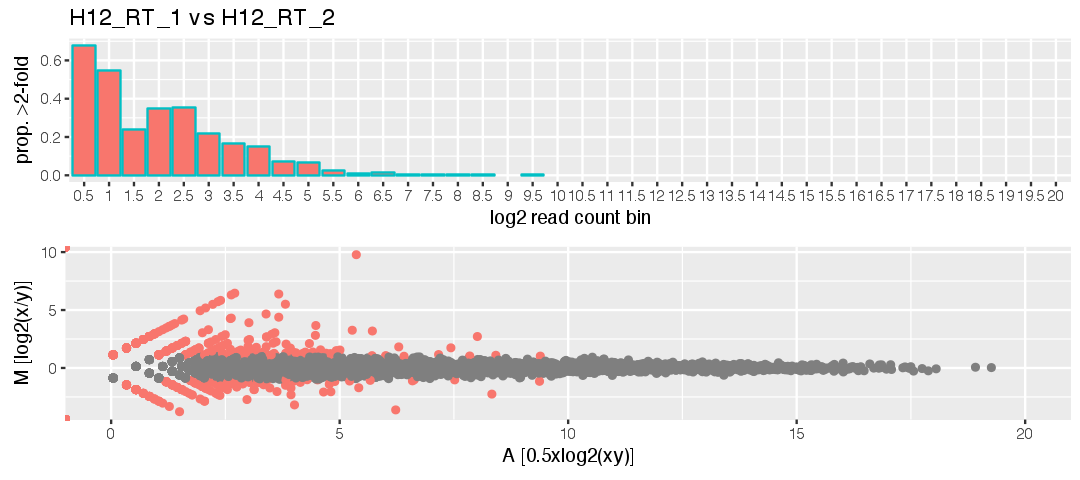

Warning message:
"Removed 14 rows containing missing values (position_stack)."Warning message:
"Removed 3477 rows containing missing values (geom_point)."

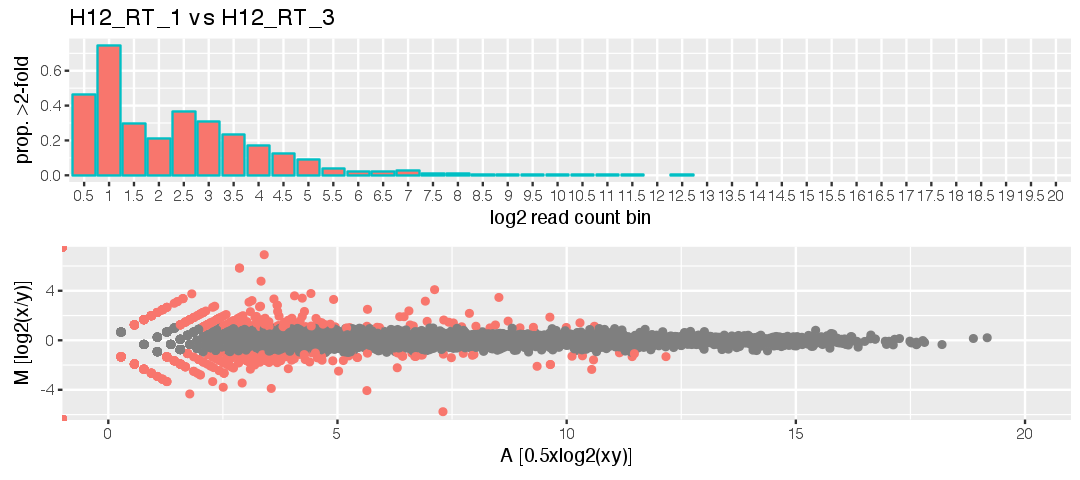

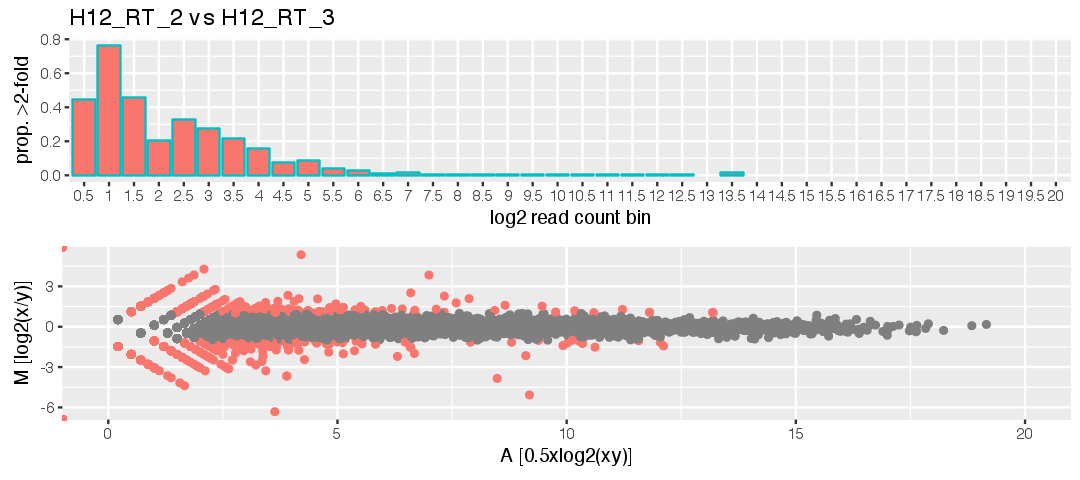

In [23]:
# normalize by DESeq method:
meta <- data.frame(row.names=colnames(DnovPM.dvir1.06.CountsMatrix.min400count), condition=DnovPM.Samples_data$V1)
DnovPMCountData<-round(DnovPM.dvir1.06.CountsMatrix)
DnovPMCountData_normByDESeq = newCountDataSet(DnovPMCountData, meta)
DnovPMCountData_normByDESeq = estimateSizeFactors(DnovPMCountData_normByDESeq)
DnovPMCountData_normByDESeq = data.frame(counts(DnovPMCountData_normByDESeq, normalized=T))

options(repr.plot.width = 9, repr.plot.height = 4)
MA_BPlot(DnovPMCountData_normByDESeq, "V_CR_1", "V_CR_2")

MA_BPlot(DnovPMCountData_normByDESeq, "V_H_1", "V_H_2")
MA_BPlot(DnovPMCountData_normByDESeq, "C6_H_1", "C6_H_2")
MA_BPlot(DnovPMCountData_normByDESeq, "H6_H_1", "H6_H_2")

MA_BPlot(DnovPMCountData_normByDESeq, "V_OV_1", "V_OV_2")
MA_BPlot(DnovPMCountData_normByDESeq, "C6_OV_1", "C6_OV_2")
MA_BPlot(DnovPMCountData_normByDESeq, "H6_OV_1", "H6_OV_2")


MA_BPlot(DnovPMCountData_normByDESeq, "V_RT_1", "V_RT_2")
MA_BPlot(DnovPMCountData_normByDESeq, "V_RT_1", "V_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "V_RT_2", "V_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "C3_RT_1", "C3_RT_2")
MA_BPlot(DnovPMCountData_normByDESeq, "C3_RT_1", "C3_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "C3_RT_2", "C3_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "C6_RT_1", "C6_RT_2")
MA_BPlot(DnovPMCountData_normByDESeq, "C6_RT_1", "C6_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "C6_RT_2", "C6_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "C12_RT_1", "C12_RT_2")
MA_BPlot(DnovPMCountData_normByDESeq, "C12_RT_1", "C12_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "C12_RT_2", "C12_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "H3_RT_1", "H3_RT_2")
MA_BPlot(DnovPMCountData_normByDESeq, "H3_RT_1", "H3_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "H3_RT_2", "H3_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "H6_RT_1", "H6_RT_2")
MA_BPlot(DnovPMCountData_normByDESeq, "H6_RT_1", "H6_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "H6_RT_2", "H6_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "H12_RT_1", "H12_RT_2")
MA_BPlot(DnovPMCountData_normByDESeq, "H12_RT_1", "H12_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "H12_RT_2", "H12_RT_3")

In [24]:
DnovPM_max_gene_expr_per_row = apply(DnovPM.dvir1.06.CountsMatrix, 1, max)
DnovPM.dvir1.06.CountsMatrix.min400count = DnovPM.dvir1.06.CountsMatrix[DnovPM_max_gene_expr_per_row >= 400,,drop=F ]

##########################################################################################
################# Remove "bad" replicates  for DE analysis ###############################
### Based on the QC analysis above, some replicates show inconsistencies that are likely due to cross tissue contamination
### during dissections. The DE analysis will exclude these replicates

## Define good replicates (propper replicate grouping and correlation)
DnovPM.GoodReps = as.character(subset(DnovPM.Samples_data, V2 != "H3_RT_1" & V2 != "H6_RT_1" & V2 != "C6_RT_1")$V2)
DnovPM.GoodSamples = subset(DnovPM.Samples_data, V2 != "H3_RT_1" & V2 != "H6_RT_1" & V2 != "C6_RT_1")

## Create counts matrix with good replicates only
DnovPM.dvir1.06.CountsMatrix.BRR=subset(DnovPM.dvir1.06.CountsMatrix, select=DnovPM.GoodReps)

## Create normalized TPM matrix with good replicates only
DnovPM.dvir1.06.TmmMatrix.BRR=subset(DnovPM.dvir1.06.TmmMatrix, select=DnovPM.GoodReps)

## Rename columns to keep replicate order
# count matrices
colnames(DnovPM.dvir1.06.CountsMatrix.BRR) = DnovPM.GoodReps

# TPM matrices
colnames(DnovPM.dvir1.06.TmmMatrix.BRR) = colnames(DnovPM.dvir1.06.CountsMatrix.BRR)


#########################################################################################
### Summary TPM table and matrix for gene level plots (includes good replicates only) ######### 

DnovPM.TPM.tmp<-DnovPM.dvir1.06.TmmMatrix.BRR
colnames(DnovPM.TPM.tmp) <- DnovPM.GoodSamples$V1
m.DnovPM.TPM.tmp <- as.data.frame(melt(as.matrix(DnovPM.TPM.tmp)))
m.DnovPM.TPM.tmp <- within(m.DnovPM.TPM.tmp, X2<-data.frame(do.call('rbind', strsplit(as.character(X2),'_',fixed=TRUE))))
m.DnovPM.TPM.tmp<-data.frame(m.DnovPM.TPM.tmp$X1, m.DnovPM.TPM.tmp$X2$X1, m.DnovPM.TPM.tmp$X2$X2, m.DnovPM.TPM.tmp$value)
colnames(m.DnovPM.TPM.tmp) <- c("FBgn_ID", "sample", "tissue", "TPM")
m.DnovPM.TPM.tmp$condition <- ifelse(grepl("C", m.DnovPM.TPM.tmp$sample, ignore.case = F), "conspecific", ifelse(grepl("H", m.DnovPM.TPM.tmp$sample, ignore.case = F), "heterospecific", "virgin"))
m.DnovPM.TPM.tmp$time <- ifelse(grepl("3", m.DnovPM.TPM.tmp$sample), "3hpm", ifelse(grepl("6", m.DnovPM.TPM.tmp$sample), "6hpm", ifelse(grepl("12", m.DnovPM.TPM.tmp$sample), "12hpm","virgin")))
m.DnovPM.TPM.tmp.c = summarySE(m.DnovPM.TPM.tmp, measurevar = "TPM", groupvars = c("FBgn_ID", "sample", "tissue", "condition", "time"))
fbgn_to_geneName<-subset(gffRecord, select=c(FBgn_ID, gene_name))
TPMse_DnovPM <- merge(fbgn_to_geneName, m.DnovPM.TPM.tmp.c, all=TRUE)
DnovPM_MeanTPMmatrix<-cast(m.DnovPM.TPM.tmp.c, FBgn_ID~sample+tissue, value ="TPM")
TPMse_DnovPM$condition = factor (TPMse_DnovPM$condition, levels = c("virgin", "conspecific", "heterospecific"))
TPMse_DnovPM$time = factor (TPMse_DnovPM$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))

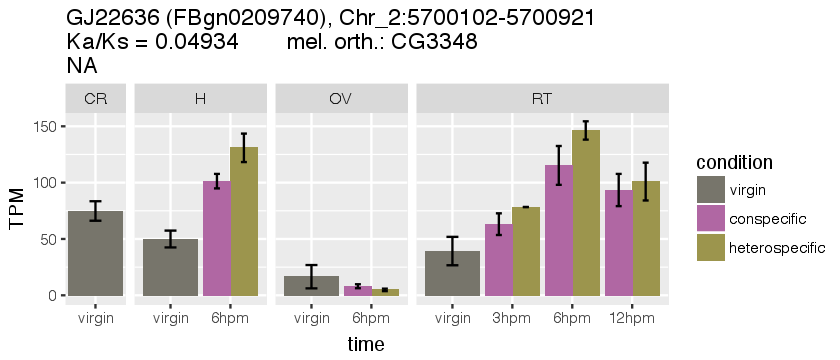

In [25]:
## plot a gene's expression like this:
options(repr.plot.width = 7, repr.plot.height = 3)

plotGenePM(TPMse_DnovPM, "GJ22636")

In [26]:
subset(paml.data, gene_name == "GJ19434")

,FBgn_ID,gene_name,chromosome,min,max,orientation,FBtr_ID,omega,H0_lnL,Damr_brSt_H0,Damr_brSt_H1,Dlum_brSt_H0,Dlum_brSt_H1,Dnov_brSt_H0,Dnov_brSt_H1,Dvir_brSt_H0,Dvir_brSt_H1,DamrNov_brSt_H0,DamrNov_brSt_H1
12438,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0442802,0.12873,-374.0663,-374.0663,-374.0663,-374.0663,-374.0663,-374.0663,-374.0663,-373.5153,-373.5153,-374.0663,-374.0663
12439,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0439591,1.52539,-631.7494,-632.0389,-631.8861,-632.0389,-632.0389,-632.0389,-629.2079,-632.0389,-630.7387,-630.8898,-630.8898
12440,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0442700,0.30853,-741.5798,-740.5816,-740.5257,-740.4267,-740.4267,-740.5898,-740.5898,-740.5898,-740.5898,-740.5898,-740.5898
12441,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0235359,0.12332,-373.6655,-373.6655,-373.6655,-373.6655,-373.6655,-373.6655,-373.6655,-373.1153,-373.1153,-373.6655,-373.6655
12442,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0435206,1.52539,-631.7494,-632.0389,-631.8861,-632.0389,-632.0389,-632.0389,-629.2079,-632.0389,-630.7387,-630.8898,-630.8898


#### Tissue Specificity

The tissue specificty index (_S_) can be calculated for each gene using the virgin tissue samples.

In [27]:
### this is incomplete
Dnov_virgin_tissue_MeanTPMmatrix <- subset(DnovPM_MeanTPMmatrix, select=c(FBgn_ID, V_CR, V_H, V_OV, V_RT))
rownames(Dnov_virgin_tissue_MeanTPMmatrix) <- Dnov_virgin_tissue_MeanTPMmatrix[,1]
Dnov_virgin_tissue_MeanTPMmatrix[,1] <- NULL

## Differential expression analysis

#### Virgin tissue contrasts:

First we'll identify genes with tissue-biased expression in the virgin samples. We can define the samples matrix:

In [28]:
DnovPM.group <- factor(c(1,1,1,2,2,2,3,3,4,4,5,5,6,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13,14,14,14))
DnovPM.design <- model.matrix(~0+DnovPM.group)
colnames(DnovPM.design)<-levels(DnovPM.GoodSamples$V1)

After removing bad replicates, the count data need to be filtered by minimum count again and use that matrix for DE analysis:

In [29]:
DnovPM_max_gene_expr_per_row = apply(DnovPM.dvir1.06.CountsMatrix.BRR, 1, max)
DnovPM.dvir1.06.CountsMatrix.BRR.min400count = DnovPM.dvir1.06.CountsMatrix.BRR[DnovPM_max_gene_expr_per_row >= 400,,drop=F ]

Create the `DGE` object and run the general linear model:

In [30]:
DnovPM_ExpStd<-DGEList(counts = DnovPM.dvir1.06.CountsMatrix.BRR.min400count, group = DnovPM.group)
DnovPM_ExpStd<-calcNormFactors(DnovPM_ExpStd)
DnovPM_ExpStd<-estimateDisp(DnovPM_ExpStd, DnovPM.design, robust = T)
DnovPM_fit <- glmFit(DnovPM_ExpStd, DnovPM.design)

For each tissue type, pairwise contrasts need to be specified to identify tissue-biased genes:

In [31]:
virgin_RT_contrasts<- makeContrasts(V_RT.vs.V_CR=V_RT-V_CR, 
                                        V_RT.vs.V_H=V_RT-V_H,
                                        V_RT.vs.V_OV=V_RT-V_OV,
                                        levels=DnovPM.design)

virgin_OV_contrasts<- makeContrasts(V_OV.vs.V_CR=V_OV-V_CR, 
                                    V_OV.vs.V_H=V_OV-V_H,
                                    V_OV.vs.V_RT=V_OV-V_RT,
                                    levels=DnovPM.design)

virgin_H_contrasts<- makeContrasts(V_H.vs.V_CR=V_H-V_CR, 
                                    V_H.vs.V_OV=V_H-V_OV,
                                    V_H.vs.V_RT=V_H-V_RT,
                                    levels=DnovPM.design)

For each tissue, extract genes that show >2-fold abundance and FDR<0.001:

In [32]:
## RT-biased genes
lrt.RT.v.rest <- glmLRT(DnovPM_fit, contrast = virgin_RT_contrasts)
lrt.RT.v.rest.tTags <- topTags(lrt.RT.v.rest, n = NULL)
lrt.RT.v.rest.tTags.table <- lrt.RT.v.rest.tTags$table
Dnov.dvir1.06.RT.list<-rownames(subset(lrt.RT.v.rest.tTags.table, logFC.V_RT.vs.V_CR > 2 & logFC.V_RT.vs.V_H > 2 & logFC.V_RT.vs.V_OV > 2 & FDR<0.001))

## OV-biased genes
lrt.OV.v.rest <- glmLRT(DnovPM_fit, contrast = virgin_OV_contrasts)
lrt.OV.v.rest.tTags <- topTags(lrt.OV.v.rest, n = NULL)
lrt.OV.v.rest.tTags.table <- lrt.OV.v.rest.tTags$table
Dnov.dvir1.06.OV.list<-rownames(subset(lrt.OV.v.rest.tTags.table, logFC.V_OV.vs.V_CR > 2 & logFC.V_OV.vs.V_H > 2 & logFC.V_OV.vs.V_RT > 2 & FDR<0.001))

## H-biased genes
lrt.H.v.rest <- glmLRT(DnovPM_fit, contrast = virgin_H_contrasts)
lrt.H.v.rest.tTags <- topTags(lrt.H.v.rest, n = NULL)
lrt.H.v.rest.tTags.table <- lrt.H.v.rest.tTags$table
Dnov.dvir1.06.H.list<-rownames(subset(lrt.H.v.rest.tTags.table, logFC.V_H.vs.V_CR > 2 & logFC.V_H.vs.V_OV > 2 & logFC.V_H.vs.V_RT > 2 & FDR<0.001))

We can plot a heatmap of any list of genes by first extracting mean expression values from the matrix of mean TPM values, for example, for RT-biased genes:

In [33]:
Dnov.dvir1.06.RT.matrix <- subset(Dnov_virgin_tissue_MeanTPMmatrix, rownames(Dnov_virgin_tissue_MeanTPMmatrix) %in% Dnov.dvir1.06.RT.list)

In [39]:
length(Dnov.dvir1.06.RT.list) 

[1] 261

Then plot those using the `plotHeatmap` functions:

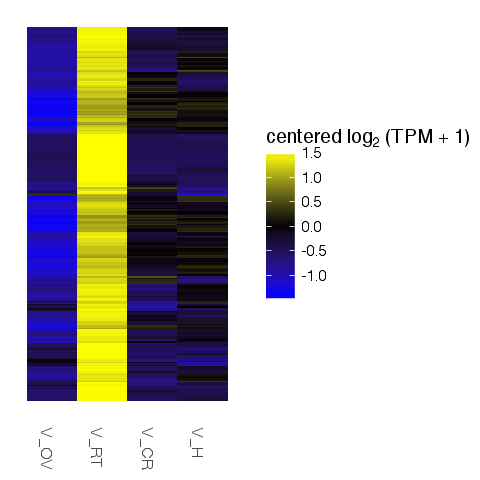

In [35]:
options(repr.plot.width = 4, repr.plot.height = 4)
plotHeatmap(Dnov.dvir1.06.RT.matrix, clustering = "both", labRow = F)

Here's a plot with RT-biased genes

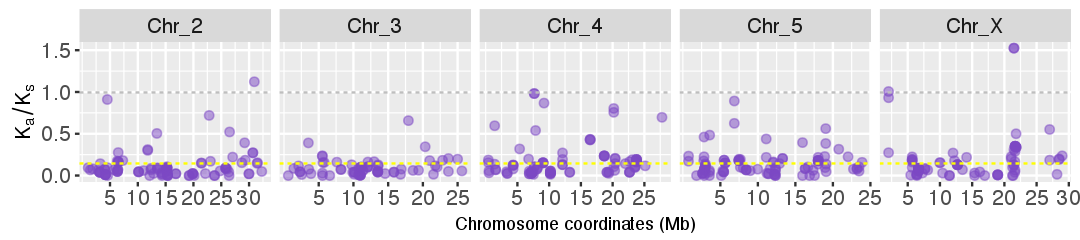

In [36]:
options(repr.plot.width = 9, repr.plot.height = 2)
ggplot(subset(paml.data, FBgn_ID %in% Dnov.dvir1.06.RT.list & omega < 800 & grepl("Chr", chromosome)), aes(max, omega)) + 
    geom_point(size=2, alpha=0.5, colour = "#7d49c3") + 
  #  geom_point(data=subset(paml.data, FBgn_ID %in% SFP_elements$`D.ame,D.lum,D.nov,D.vir` ), aes(max, omega), inherit.aes = F, size=2, alpha=0.5, colour = "#4f922a") + 
    geom_hline(yintercept = 0.15, linetype="dashed", colour = "yellow") + 
    geom_hline(yintercept = 1, linetype="dashed", colour = "gray")  + 
    facet_grid(~chromosome, scales = "free_x") + 
#    scale_colour_manual(name = "", values =c("#7aa457"="#7aa457","#9e6ebd"="#9e6ebd"), labels = c("SFPs","EB biased")) + 
    scale_x_continuous(breaks=seq(5000000,30000000,5000000), labels=expression("5", "10", "15", "20", "25", "30")) + 
    xlab ("Chromosome coordinates (Mb)") + 
    labs(y=expression(K[a]/K[s])) + 
#    geom_text_repel(data=subset(paml.data, FBgn_ID %in% Dnov.dvir1.06.RT.list & omega > 0.95 & omega < 800), aes(label = gene_name), size =3, force = 30, colour = "#7d49c3") +
  #  geom_text_repel(data=subset(paml.data, gene_name == "GJ21515"), aes(label = gene_name), size =3, force = 30, colour = "#4f922a") +
  #  geom_text_repel(data=subset(paml.data, FBgn_ID %in% SFP_elements$`D.ame,D.lum,D.nov,D.vir` & omega > 0.8), aes(label = gene_name), size =3, force = 4, colour = "#4f922a") +
    theme(axis.title.x = element_text(face = "bold", size = 10, vjust=0.1), axis.text.x=element_text(face = "bold", size = 12),axis.text.y = element_text(face = "bold", size = 12), axis.title.y = element_text(face = "bold.italic", size = 12, vjust=0.1), strip.text=element_text(face="bold", size = 12))



#### Reproductive tract post-mating contrasts:

In [37]:
# create RT-specific count matrix and define groups/design
DnovPM_CountsMatrix_RT = subset(DnovPM.dvir1.06.CountsMatrix.BRR.min400count, select=grepl("RT", colnames(DnovPM.dvir1.06.CountsMatrix.BRR.min400count)))


In [45]:
## filter this matrix by minimum read count
DnovPM_max_gene_expr_per_row = apply(DnovPM_CountsMatrix_RT, 1, max)
DnovPM_CountsMatrix_RT.min400 = DnovPM_CountsMatrix_RT[DnovPM_max_gene_expr_per_row >= 400,,drop=F ]

In [ ]:
######
RT.group <- factor(c(1,1,1,2,2,2,3,3,4,4,4,5,5,6,6,7,7,7))
RT.design <- model.matrix(~0+RT.group)
colnames(RT.design)<-c("C12_RT", "C3_RT", "C6_RT", "H12_RT", "H3_RT", "H6_RT", "V_RT")

In [ ]:
# create edgeR DE object and run glm
DnovPM_DGElist_RT<-DGEList(counts = DnovPM_CountsMatrix_RT.min400, group = RT.group)
DnovPM_DGElist_RT<-calcNormFactors(DnovPM_DGElist_RT)
DnovPM_DGElist_RT<-estimateDisp(DnovPM_DGElist_RT, RT.design, robust = T)
DnovPM_RT_fit <- glmFit(DnovPM_DGElist_RT, RT.design)

In [ ]:
# define contrasts
con_virgin_contrasts <- makeContrasts(C3.vs.V=C3_RT-V_RT, C6.vs.V=C6_RT-V_RT, C12.vs.V=C12_RT-V_RT, levels = RT.design)
het_virgin_contrasts <- makeContrasts(H3.vs.V=H3_RT-V_RT, H6.vs.V=H6_RT-V_RT, H12.vs.V=H12_RT-V_RT, levels = RT.design)

In [ ]:
# identify overall con_vs_het
RT_con.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts)
RT_con.vs.virgin.tTags <- topTags(RT_con.vs.virgin, n = NULL)
RT_con.vs.virgin.tTags.table <- RT_con.vs.virgin.tTags$table
RT_con.vs.virgin.tTags.table$FBgn_ID <- rownames(RT_con.vs.virgin.tTags.table)

RT_het.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts)
RT_het.vs.virgin.tTags <- topTags(RT_het.vs.virgin, n = NULL)
RT_het.vs.virgin.tTags.table <- RT_het.vs.virgin.tTags$table
RT_het.vs.virgin.tTags.table$FBgn_ID <- rownames(RT_het.vs.virgin.tTags.table)

In [48]:
head(RT_con.vs.virgin.tTags.table)

,logFC.C3.vs.V,logFC.C6.vs.V,logFC.C12.vs.V,logCPM,LR,PValue,FDR,FBgn_ID
FBgn0198861,2.9935293,1.204777,0.3051668,5.241462,873.2722,5.550898e-189,3.710220e-185,FBgn0198861
FBgn0199412,2.0701762,3.504898,4.0818578,7.766424,659.5361,1.246726e-142,4.166558e-139,FBgn0199412
FBgn0198037,-1.8604222,-2.203550,-2.8935859,3.309744,337.8169,6.479754e-73,1.443689e-69,FBgn0198037
FBgn0208092,2.3176135,3.063180,2.0314281,6.720275,294.3007,1.703014e-63,2.845737e-60,FBgn0208092
FBgn0209375,0.7611869,2.202677,2.0905668,5.235392,259.1301,6.933999e-56,9.269370e-53,FBgn0209375
FBgn0200611,1.3625801,2.026408,1.7716102,7.202215,249.1764,9.861973e-54,1.082821e-50,FBgn0200611


In [ ]:
# Pairwise contrasts
# identify DE genes: C3_RT vs V_RT
RT_con.3hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts[,"C3.vs.V"])
RT_con.3hrs.vs.virgin.tTags <- topTags(RT_con.3hrs.vs.virgin, n = NULL)
RT_con.3hrs.vs.virgin.tTags.table <- RT_con.3hrs.vs.virgin.tTags$table
RT_con.3hrs.vs.virgin.Up.list <- rownames(subset(RT_con.3hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_con.3hrs.vs.virgin.Down.list <- rownames(subset(RT_con.3hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# identify DE genes: C6_RT vs V_RT
RT_con.6hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts[,"C6.vs.V"])
RT_con.6hrs.vs.virgin.tTags <- topTags(RT_con.6hrs.vs.virgin, n = NULL)
RT_con.6hrs.vs.virgin.tTags.table <- RT_con.6hrs.vs.virgin.tTags$table
RT_con.6hrs.vs.virgin.Up.list <- rownames(subset(RT_con.6hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_con.6hrs.vs.virgin.Down.list <- rownames(subset(RT_con.6hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# identify DE genes: C12_RT vs V_RT
RT_con.12hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts[,"C12.vs.V"])
RT_con.12hrs.vs.virgin.tTags <- topTags(RT_con.12hrs.vs.virgin, n = NULL)
RT_con.12hrs.vs.virgin.tTags.table <- RT_con.12hrs.vs.virgin.tTags$table
RT_con.12hrs.vs.virgin.Up.list <- rownames(subset(RT_con.12hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_con.12hrs.vs.virgin.Down.list <- rownames(subset(RT_con.12hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# identify DE genes: H3_RT vs V_RT
RT_het.3hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts[,"H3.vs.V"])
RT_het.3hrs.vs.virgin.tTags <- topTags(RT_het.3hrs.vs.virgin, n = NULL)
RT_het.3hrs.vs.virgin.tTags.table <- RT_het.3hrs.vs.virgin.tTags$table
RT_het.3hrs.vs.virgin.Up.list <- rownames(subset(RT_het.3hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_het.3hrs.vs.virgin.Down.list <- rownames(subset(RT_het.3hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# identify DE genes: H6_RT vs V_RT
RT_het.6hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts[,"H6.vs.V"])
RT_het.6hrs.vs.virgin.tTags <- topTags(RT_het.6hrs.vs.virgin, n = NULL)
RT_het.6hrs.vs.virgin.tTags.table <- RT_het.6hrs.vs.virgin.tTags$table
RT_het.6hrs.vs.virgin.Up.list <- rownames(subset(RT_het.6hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_het.6hrs.vs.virgin.Down.list <- rownames(subset(RT_het.6hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# identify DE genes: H12_RT vs V_RT
RT_het.12hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts[,"H12.vs.V"])
RT_het.12hrs.vs.virgin.tTags <- topTags(RT_het.12hrs.vs.virgin, n = NULL)
RT_het.12hrs.vs.virgin.tTags.table <- RT_het.12hrs.vs.virgin.tTags$table
RT_het.12hrs.vs.virgin.Up.list <- rownames(subset(RT_het.12hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_het.12hrs.vs.virgin.Down.list <- rownames(subset(RT_het.12hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))


RT_UP_3hrs_candidates <- list(Conspecific = RT_con.3hrs.vs.virgin.Up.list, Heterospecific = RT_het.3hrs.vs.virgin.Up.list)
RT_UP_6hrs_candidates <- list(Conspecific = RT_con.6hrs.vs.virgin.Up.list, Heterospecific = RT_het.6hrs.vs.virgin.Up.list)
RT_UP_12hrs_candidates <- list(Conspecific = RT_con.12hrs.vs.virgin.Up.list, Heterospecific = RT_het.12hrs.vs.virgin.Up.list)
RT_Down_3hrs_candidates <- list(Conspecific = RT_con.3hrs.vs.virgin.Down.list, Heterospecific = RT_het.3hrs.vs.virgin.Down.list)
RT_Down_6hrs_candidates <- list(Conspecific = RT_con.6hrs.vs.virgin.Down.list, Heterospecific = RT_het.6hrs.vs.virgin.Down.list)
RT_Down_12hrs_candidates <- list(Conspecific = RT_con.12hrs.vs.virgin.Down.list, Heterospecific = RT_het.12hrs.vs.virgin.Down.list)

# Rearrange into lists of lists, and partition by species
RT_UP_3hrs_combs <- unlist(lapply(1:length(RT_UP_3hrs_candidates), function(j) combn(names(RT_UP_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_6hrs_combs <- unlist(lapply(1:length(RT_UP_6hrs_candidates), function(j) combn(names(RT_UP_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_12hrs_combs <- unlist(lapply(1:length(RT_UP_12hrs_candidates), function(j) combn(names(RT_UP_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_3hrs_combs <- unlist(lapply(1:length(RT_Down_3hrs_candidates), function(j) combn(names(RT_Down_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_6hrs_combs <- unlist(lapply(1:length(RT_Down_6hrs_candidates), function(j) combn(names(RT_Down_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_12hrs_combs <- unlist(lapply(1:length(RT_Down_12hrs_candidates), function(j) combn(names(RT_Down_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)

names(RT_UP_3hrs_combs) <- sapply(RT_UP_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_6hrs_combs) <- sapply(RT_UP_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_12hrs_combs) <- sapply(RT_UP_12hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_3hrs_combs) <- sapply(RT_Down_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_6hrs_combs) <- sapply(RT_Down_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_12hrs_combs) <- sapply(RT_Down_12hrs_combs, function(i) paste0(i, collapse = ","))

RT_UP_3hrs_elements <- lapply(RT_UP_3hrs_combs, function(i) Setdiff(RT_UP_3hrs_candidates[i], RT_UP_3hrs_candidates[setdiff(names(RT_UP_3hrs_candidates), i)]))
RT_UP_6hrs_elements <- lapply(RT_UP_6hrs_combs, function(i) Setdiff(RT_UP_6hrs_candidates[i], RT_UP_6hrs_candidates[setdiff(names(RT_UP_6hrs_candidates), i)]))
RT_UP_12hrs_elements <- lapply(RT_UP_12hrs_combs, function(i) Setdiff(RT_UP_12hrs_candidates[i], RT_UP_12hrs_candidates[setdiff(names(RT_UP_12hrs_candidates), i)]))
RT_Down_3hrs_elements <- lapply(RT_Down_3hrs_combs, function(i) Setdiff(RT_Down_3hrs_candidates[i], RT_Down_3hrs_candidates[setdiff(names(RT_Down_3hrs_candidates), i)]))
RT_Down_6hrs_elements <- lapply(RT_Down_6hrs_combs, function(i) Setdiff(RT_Down_6hrs_candidates[i], RT_Down_6hrs_candidates[setdiff(names(RT_Down_6hrs_candidates), i)]))
RT_Down_12hrs_elements <- lapply(RT_Down_12hrs_combs, function(i) Setdiff(RT_Down_12hrs_candidates[i], RT_Down_12hrs_candidates[setdiff(names(RT_Down_12hrs_candidates), i)]))

### Draw a VennDiagram of each element
RT_UP_3hrs_Vdiag<-venn.diagram(RT_UP_3hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_UP_6hrs_Vdiag<-venn.diagram(RT_UP_6hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_UP_12hrs_Vdiag<-venn.diagram(RT_UP_12hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")
grid.arrange(gTree(children=RT_UP_3hrs_Vdiag), gTree(children=RT_UP_6hrs_Vdiag), gTree(children=RT_UP_12hrs_Vdiag))

RT_Down_3hrs_Vdiag<-venn.diagram(RT_Down_3hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_Down_6hrs_Vdiag<-venn.diagram(RT_Down_6hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_Down_12hrs_Vdiag<-venn.diagram(RT_Down_12hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")
    

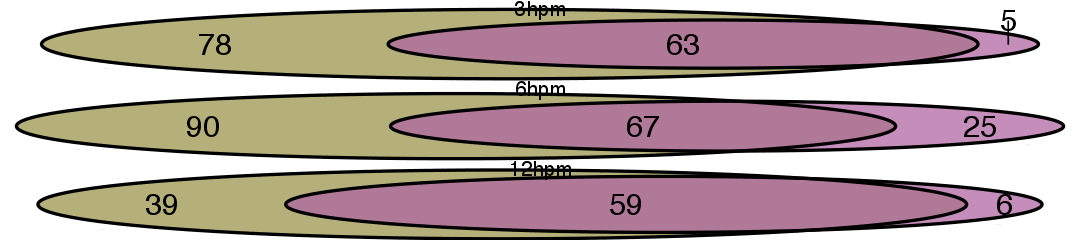

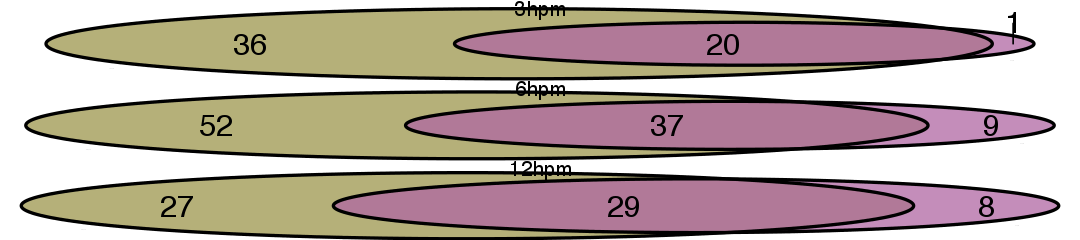

In [47]:
grid.arrange(gTree(children=RT_Down_3hrs_Vdiag), gTree(children=RT_Down_6hrs_Vdiag), gTree(children=RT_Down_12hrs_Vdiag))